# Applied Data Science Capstone

### Predicting Accident Severity using Seattle Data Set

Chee Loh

# Introduction

## Problem Statement

Traffic accidents can cause inconvenience not only for the parties involved, but also surrounding drivers who are stuck in a standstill.
Millions of accidents occur in the United States each year leading to increased commute time, property damage, and even personal injury.

How can we minimize traffic congestion due to severe automotive accidents? How can we predict accident severity based on outside factors such as weather and road conditions in order to alert drivers of an increased driving risk?  

In order to accomplish this task, a prediction model can be used to identify what factors contribute to the severity of a traffic accident. By using a large data set of traffic accidents in Seattle compiled from 2004 to 2020, various environmental as well as personal factors which contribute to the severity of the accident can be highlighted. Furthermore, this data analysis can be used to predict the severity of new accidents which have yet to occur.

Daily driver commuters as well as emergency service personnel can benefit from this information by using it to avoid high congestion areas(thus reducing overall congestion) and minimizing their time to destination, whether it is work, school, or the scene of the accident itself.

## Data

In order to accomplish the task of predicting accident severity, there are various features from the sample data set “Data-Collisions.csv” that can be used to predict the severity of motor vehicle accidents. Such features include “WEATHER”, which could be used to highlight if inclement weather would lead to a more severe accident.

We could also reveal other interesting conclusions from the dataset such as if severe accidents occur more on specific days of the week or in a particular location in the city.

All of these factors are significant variables which could help to predict the severity of a car accident that has already happened or that may happen.



## Methodology


For this project, I would like to use a classification model in order to predict accident severity(non-severe vs. severe). Various supervised learning algorithms can be used such as K-Nearest Neighbours(KNN), Decision Trees(DT), Logistic Regression(LR), and Support Vector Machines(SVM). In this report, all four methods of classifications will be analyzed. First, the raw data set will be cleaned and formatted in order to analyze more efficiently. The data set will then be split into a training set and a testing set. The training set of data will be used to fit each classification model. Then, the fitted model will be tested with the test set of data in order to evaluate its accuracy. Various accuracy scores will be reported for each classification model such as Jaccard Score and F1-Score.

In [25]:
# First, import the appropriate modules and tools for this analysis
import itertools
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

# Save the .csv data set to a dataframe using pandas
!wget -O Data-Collisions.csv https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
    
    
df_temp = pd.read_csv('Data-Collisions.csv')

--2020-09-12 20:10:43--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73917638 (70M) [text/csv]
Saving to: ‘Data-Collisions.csv’

100%[======================================>] 73,917,638  46.1MB/s   in 1.5s   

2020-09-12 20:10:45 (46.1 MB/s) - ‘Data-Collisions.csv’ saved [73917638/73917638]



/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
# Extract only significant information from dataframe
df = df_temp[["SEVERITYCODE", "INCDTTM", "WEATHER"]]

# Select 50,000 random incidents from data set for analysis 
chosen_idx = np.random.choice(len(df.index), replace = True, size = 50000) 
df = df.iloc[chosen_idx] 

# Replace empty values with "Unknown"
df = df.fillna("Unknown")

# Convert the dates and times of incidents to a datetime object
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

# Extract day of the week information(Monday=0 thru Sunday=6)
df['DAYOFWEEK'] = df['INCDTTM'].dt.dayofweek

# Reorder dataframe and Extract Features and use One Hot Encoding to convert categorical variables to binary variables and append them to the feature dataframe
Features = df[["DAYOFWEEK"]]
Features = pd.concat([Features,pd.get_dummies(df['WEATHER'])], axis=1)

# Save features and actual results to appropriate dataframes
X = Features
y = df['SEVERITYCODE'].values

print(X.head(10))
print(y[0:10])

        DAYOFWEEK  Blowing Sand/Dirt  Clear  Fog/Smog/Smoke  Other  Overcast  \
7836            1                  0      1               0      0         0   
54310           0                  0      1               0      0         0   
93813           3                  0      0               0      0         0   
163207          4                  0      0               0      0         0   
47738           2                  0      0               0      0         0   
111941          6                  0      1               0      0         0   
14809           3                  0      0               0      0         0   
160860          5                  0      0               0      0         1   
107872          4                  0      0               0      0         0   
11375           3                  0      0               0      0         0   

        Partly Cloudy  Raining  Severe Crosswind  Sleet/Hail/Freezing Rain  \
7836                0        0           

In [27]:
# Normalize data
X= preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


## First, let's see if the day of the week influences accident severity

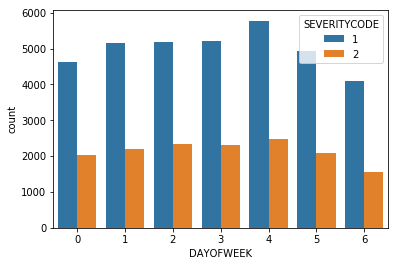

In [28]:
bins = np.linspace(df.DAYOFWEEK.min(), df.DAYOFWEEK.max(), 10)
g = sns.countplot(x="DAYOFWEEK", hue="SEVERITYCODE", data=df)

plt.show()

From the above Seaborn plot, we can see the relationship between each day of the week and the number and severity of accidents from our 50,000 sample point data set.
Some interesting observations are that more accidents seem to occur on Friday and as a result more severe accidents occur on Friday as well. The least amount of accidents occur on Sunday.

# K-Nearest Neighbor

In [29]:
# Create train and test groups
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

# Import library
from sklearn.neighbors import KNeighborsClassifier

# Calculate mean of accuracy over multiple K-values
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    # std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.5865, 0.6673, 0.6395, 0.6406, 0.6341, 0.6662, 0.6596, 0.6661,
       0.6253])

In [30]:
# Set best k-value after calculating accuracies
k = 2
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

# Use model to create prediction of the test set
yhat = neigh.predict(X_test)
yhat[0:5]

# Evaluate accuracy of k-value
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.66075
Test set Accuracy:  0.6673


### Calculate accuracy scores

In [31]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

# Calculate accuracy scores with k = 7
KNN_Jaccard_Score = jaccard_similarity_score(y_test, yhat)
print("KNN Jaccard Score = ", KNN_Jaccard_Score)

KNN_F1_Score = f1_score(y_test, yhat, average='weighted') 
print("KNN F1 Score = ", KNN_F1_Score)

KNN Jaccard Score =  0.6673
KNN F1 Score =  0.6115771949263031


# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
   
# Create a decision tree object
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

# Fit the tree to the train set generated prior
loanTree.fit(X_trainset,y_trainset)

# Create prediction from fit model using test set
predTree = loanTree.predict(X_testset)

### Calculate accuracy scores

In [48]:
DT_Jaccard_Score = jaccard_similarity_score(y_testset, predTree)
print("Decision Tree Jaccard Score = ", DT_Jaccard_Score)

DT_F1_Score = f1_score(y_testset, predTree, average='weighted', labels=np.unique(predTree)) 
print("Decision Tree F1 Score = ", DT_F1_Score)

Decision Tree Jaccard Score =  0.7008666666666666
Decision Tree F1 Score =  0.8241288754752478


# Support Vector Machine

In [49]:
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split( X, y, test_size=0.2, random_state=4)

# Import SVM model
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='auto')
clf.fit(svm_X_train, svm_y_train) 

svm_yhat = clf.predict(svm_X_test)
svm_yhat [0:5]

array([1, 1, 1, 1, 1])

### Calculate accuracy scores

In [50]:
# Calculate accuracy scores
SVM_Jaccard_Score = jaccard_similarity_score(svm_y_test, svm_yhat)
print("SVM Jaccard Score = ", SVM_Jaccard_Score)

SVM_F1_Score = f1_score(svm_y_test, svm_yhat, average='weighted', labels=np.unique(svm_yhat)) 
print("SVM F1 Score = ", SVM_F1_Score)

SVM Jaccard Score =  0.7042
SVM F1 Score =  0.8264288229081094


# Logistic Regression

In [51]:
LR_X_train, LR_X_test, LR_y_train, LR_y_test = train_test_split( X, y, test_size=0.2, random_state=4)

# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(LR_X_train,LR_y_train)

LR_yhat = LR.predict(LR_X_test)

### Calculate accuracy scores

In [55]:
# Calculate accuracy scores
from sklearn.metrics import log_loss
LR_Jaccard_Score = jaccard_similarity_score(LR_y_test, LR_yhat)
print("LR Jaccard Score = ", LR_Jaccard_Score)

LR_F1_Score = f1_score(LR_y_test, LR_yhat, average='weighted', labels=np.unique(LR_yhat)) 
print("LR F1 Score = ", LR_F1_Score)

yhat_prob = LR.predict_proba(LR_X_test)
LR_Log_Loss = log_loss(y_test, yhat_prob)
print("LR Log Loss = ", LR_Log_Loss)

LR Jaccard Score =  0.7042
LR F1 Score =  0.8264288229081094
LR Log Loss =  0.5942734858800851


## Results

In [56]:
data = {'Algorithm':  ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
        'Jaccard': [KNN_Jaccard_Score, DT_Jaccard_Score, SVM_Jaccard_Score, LR_Jaccard_Score],
        'F1-score': [KNN_F1_Score, DT_F1_Score, SVM_F1_Score, LR_F1_Score],
        'LogLoss': ['NA', 'NA', 'NA', LR_Log_Loss],
        }

results_df = pd.DataFrame (data, columns = ['Algorithm','Jaccard','F1-score','LogLoss'])

print (results_df)

             Algorithm   Jaccard  F1-score   LogLoss
0                  KNN  0.667300  0.611577        NA
1        Decision Tree  0.700867  0.824129        NA
2                  SVM  0.704200  0.826429        NA
3  Logistic Regression  0.704200  0.826429  0.594273


After compiling our results in the above table, we can see that our SVM model and our Logistic Regression model both produce accuracy scores of 70.4% and F1 scores of 82.6%. As a result, either of these models should yield predicted accident severity with roughly 70% accuracy given the training and test data sets we used.



## Discussion

The KNN algorithm takes quite a bit of processing time during fitting and a secondary step of finding the optimal K-value requires further analysis by the user. As such, this is not a recommend model in this use case.

As previously shown, the day of the week does not seem to have any significant correlation to the severity of accidents either.

With these models, we can now predict accident severity using weather attributes.

## Conclusion

This capstone project was very valuable for providing further practice with using machine learning classification models using real-world data sets. This process can be re-used in many applications and can provide valuable information to any user in a variety of ways. Further investigation needs to be done in order to see how very large data sets should be analyzed and modelled. The processing power and processing time for such a large data set was somewhat prohibitive and I needed to take a smaller sample dataset in order to proceed with model creation and evaluation. In the future, I will also look at other accuracy and evaluation metrics for these models to yield better results.